In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.stats
from scipy.stats import iqr
import matplotlib.pyplot as plt

data_path = '../../evaluation/ribench/ribench_sample/'
model_path = './model/'

def norm_err(y_test, p_test):
    """
    Calculates the normalized error between a true and predicted reference interval as proposed in CA-125 paper submitted to Sci. Reports
    
    Arguments:
        y_test:   true RI
        p_test:   predicted RI
        
    Returns:
        normalized error
    """
    return np.mean([np.abs(i-j) for i,j in zip([-1, 1], (p_test-y_test.mean())/y_test.std())])


In [2]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [3]:
# load data
test_x = pickle.load(open(data_path+'x.pkl', 'rb'))
test_y = pickle.load(open(data_path+'y.pkl', 'rb'))
test_files = pickle.load(open(data_path+'files.pkl', 'rb'))
test_analytes = np.array([i.split('/')[-2] for i in test_files])
idx_remove = np.where(test_analytes!='CRP')[0]
test_x = [test_x[i] for i in idx_remove]
test_y = [test_y[i] for i in idx_remove]
test_files = [test_files[i] for i in idx_remove]
test_analytes = np.array([test_analytes[i] for i in idx_remove])
idx_remove = np.where(test_analytes!='LDH')[0]
test_x = [test_x[i] for i in idx_remove]
test_y = [test_y[i] for i in idx_remove]
test_files = [test_files[i] for i in idx_remove]
test_analytes = [test_analytes[i] for i in idx_remove]


In [4]:
# scale data

data_means = [i.mean() for i in test_x]
data_std = [i.std() for i in test_x]
data_scaled = [(i-i.mean())/i.std() for i in test_x]


In [5]:
# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))


In [6]:
# extract features
features = np.array([extract_features(i) for i in data_scaled])
features.shape


(791, 100, 1)

In [7]:
# predict
test_p = model.predict(features)
test_p = scalery.inverse_transform(test_p)

# for i in range(len(test_y)):
#     if test_files[i].split('/')[-2]=='CRP':
#         test_y[i][0] = 0
#         test_p[i][0] = -data_means[i]/data_std[i]
        

25/25 [==============================] - 1s 34ms/step


In [8]:
len(np.where(np.isnan(test_p))[0])


0

In [9]:
# test_p = [(i*j)+k for i,j,k in zip(test_p, data_std, data_means)]


In [10]:
test_y_scaled = [(i-j)/k for i,j,k in zip(test_y, data_means, data_std)]


In [11]:
test_p_ris = [i[[1, -3]] for i in test_p]


In [12]:
errors = [norm_err(i, j) for i,j in zip(test_y_scaled, test_p_ris)]
errors = np.array(errors)


In [13]:
np.mean(errors)


0.13715298179602992

In [14]:
np.median(errors)


0.09411412477493286

In [15]:
error_threshold = 0.2
len(np.where(errors<=error_threshold)[0])/len(errors)


0.8482932996207333

In [16]:
error_threshold = 0.1
len(np.where(errors<=error_threshold)[0])/len(errors)


0.5309734513274337

In [17]:
# plt.hist(errors, 100, alpha=0.5, edgecolor='k');


In [18]:
test_analytes = np.array([i.split('/')[-2] for i in test_files])


In [19]:
analyte_order = ['Hb','Ca','FT4','AST','LACT','GGT','TSH','IgE']
df = pd.DataFrame({
    'Mean Err': [np.mean(errors[np.where(test_analytes==i)[0]]) for i in analyte_order],
    'Median Err': [np.median(errors[np.where(test_analytes==i)[0]]) for i in analyte_order],
    'Accuracy': [len(np.where(errors[np.where(test_analytes==i)[0]]<=0.2)[0])/len(np.where(test_analytes==i)[0]) for i in analyte_order]
}, index=analyte_order)

df


,Mean Err,Median Err,Accuracy
Hb,0.141687,0.082011,0.857143
Ca,0.243478,0.080996,0.730337
FT4,0.090267,0.071436,0.966292
AST,0.124031,0.107977,0.854369
LACT,0.101240,0.080854,0.900000
GGT,0.136515,0.118113,0.869565
TSH,0.143596,0.123711,0.742857
IgE,0.122569,0.106090,0.871287


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_pdf_from_quantiles(values, weight, num_points=1000):
    """
    Plots the PDF of a distribution from given quantiles and corresponding values.
    
    Parameters:
    - quantiles: array-like, quantile values (e.g., [0.05, 0.25, 0.50, 0.75, 0.95])
    - values: array-like, corresponding values for the quantiles (e.g., [-1.64, -0.67, 0.0, 0.67, 1.64])
    - num_points: int, number of points to use for plotting (default: 1000)
    """
    
    quantiles = [0.01, 0.025, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975, 0.99]

    # Ensure input is numpy array
    quantiles = np.array(quantiles)
    values = np.array(values)
    
    # Create an interpolation of the CDF
    cdf = interp1d(values, quantiles, kind='cubic', fill_value="extrapolate")
    
    # Generate a range of values for plotting
    x = np.linspace(min(values), max(values), num_points)
    y_cdf = cdf(x)
        
    # Estimate the PDF by differentiating the CDF
    pdf = np.gradient(y_cdf, x)
    
    # Plot the PDF
    plt.plot(x, pdf*weight, label='Estimated PDF')


In [21]:
test_analytes = np.array(test_analytes)


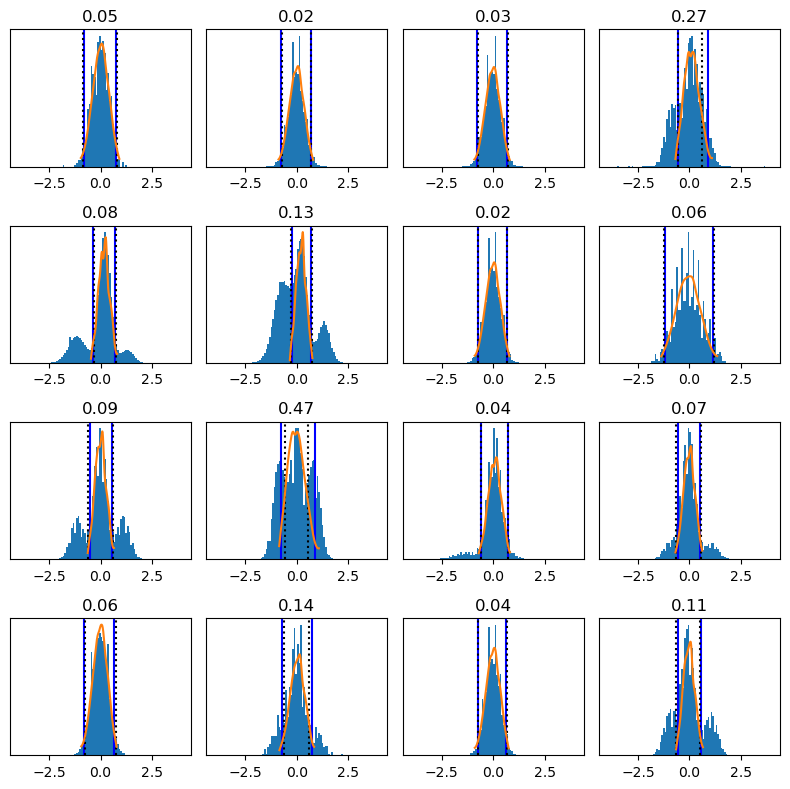

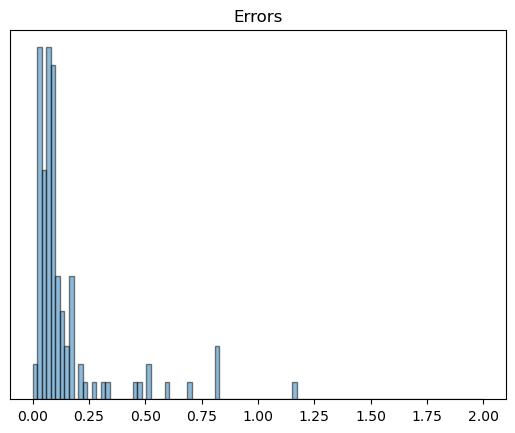

In [22]:
nr = 4
nc = 4
# idx = np.random.choice(len(test_x), nr*nc)
check_analyte = 'Hb'
idx = np.where(test_analytes==check_analyte)[0]
idx = np.random.choice(idx, nr*nc)
# idx = np.random.choice(idx[np.where(errors[idx]>0.20)[0]], nr*nc)
plt.figure(figsize=(8, 8))
for c,i in enumerate(idx):
    plt.subplot(nr, nc, c+1)
    plt.hist(data_scaled[i], np.linspace(-4, 4, 101), density=True);
    for j in test_p_ris[i]:
        plt.axvline(j, c='b')
    for j in test_y_scaled[i]:
        plt.axvline(j, c='k', linestyle=':')
    plt.yticks([])
    plt.title(round(errors[i], 2))
    plot_pdf_from_quantiles(test_p[i][:-1], test_p[i][-1])
plt.tight_layout()
plt.figure()
plt.hist(errors[np.where(test_analytes==check_analyte)[0]], np.linspace(0, 2, 100), edgecolor='k', alpha=0.5);
plt.yticks([])
plt.title('Errors');
